In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json, os
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("./data/transactions_f.csv")
df

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,is_weekend,daypart,is_refund,amount_pos,amount_abs,amount_log1p,zip_str,zip3,mcc_desc,is_fraud
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,...,0,late_night,1,0.00,77.00,0.000000,58523,585,Miscellaneous Food Stores,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,...,0,late_night,0,14.57,14.57,2.745346,52722,527,Department Stores,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,...,0,late_night,0,80.00,80.00,4.394449,92084,920,Money Transfer,0
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,...,0,late_night,0,46.41,46.41,3.858833,20776,207,Drinking Places (Alcoholic Beverages),0
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464,...,0,late_night,0,4.81,4.81,1.759581,10464,104,Book Stores,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807581,23761861,2019-10-31 23:52:00,234,5178,40.00,Swipe Transaction,27092,Dallas,TX,75208,...,0,evening,0,40.00,40.00,3.713572,75208,752,Money Transfer,0
7807582,23761862,2019-10-31 23:54:00,672,5001,12.93,Chip Transaction,47508,Cosby,TN,37722,...,0,evening,0,12.93,12.93,2.634045,37722,377,Beauty and Barber Shops,0
7807583,23761863,2019-10-31 23:54:00,1384,3723,67.01,Chip Transaction,58136,Williamson,GA,30292,...,0,evening,0,67.01,67.01,4.219655,30292,302,Eating Places and Restaurants,0
7807584,23761868,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792,...,0,evening,0,1.11,1.11,0.746688,91792,917,Miscellaneous Food Stores,0


In [4]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["day"] = df["date"].dt.floor("D")
df["doy"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.to_period("M")

GLOBAL_RATE = df["is_fraud"].mean()
TOP_CITIES = 3        # 시계열을 보여줄 상위 도시 수
TOP_MCC_PER_CITY = 4  # 각 도시에서 상위 업종 수
TOP_STATES = 10       # season heatmap에 표시할 상위 주

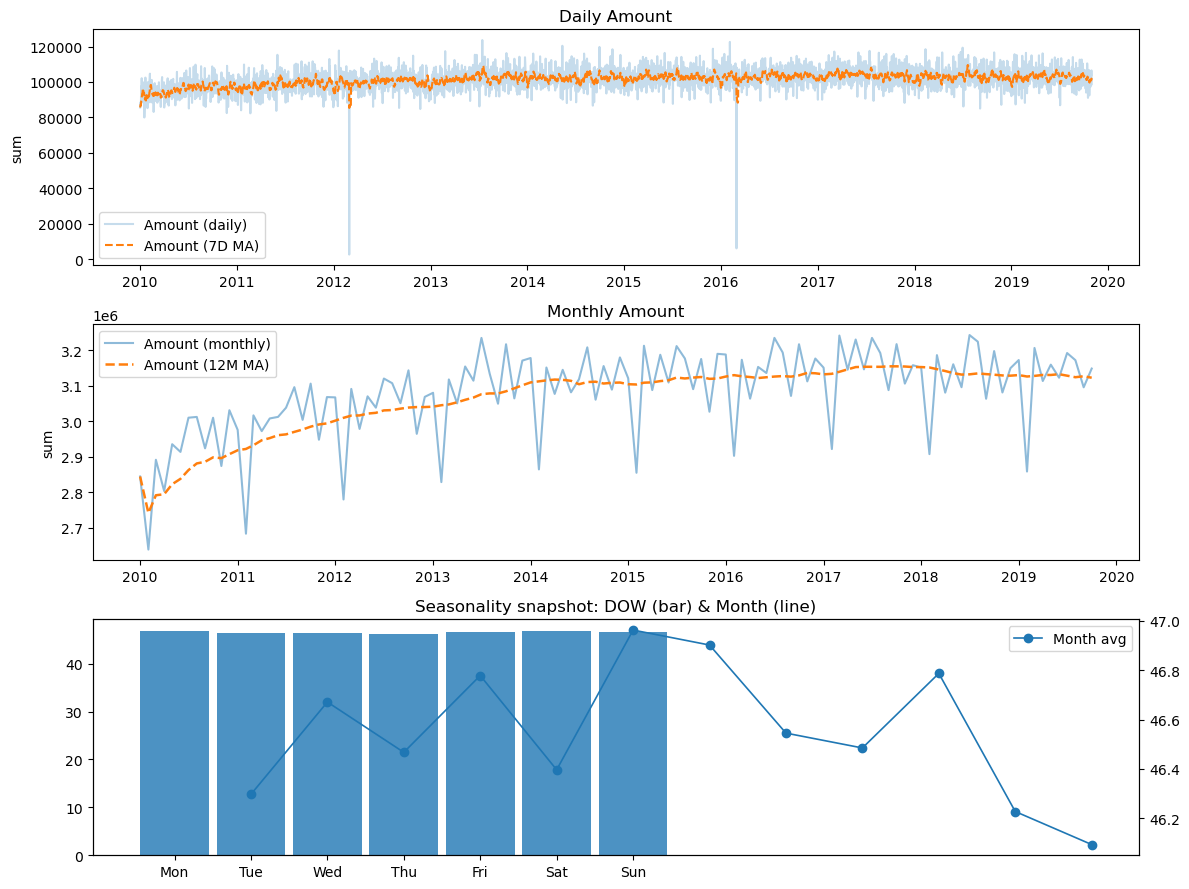

{'lag7_corr_daily_amount': 0.374}


In [5]:
# 1. 금액 시계열 분석 (Amount time series)
# 일/월 금액 집계 (refund 제외: amount_pos)
daily_amt = df.groupby("day")["amount_pos"].sum()
monthly_amt = df.groupby("month")["amount_pos"].sum().to_timestamp()

# 7일/12개월 이동평균
daily_ma7 = daily_amt.rolling(7, min_periods=1).mean()
monthly_ma12= monthly_amt.rolling(12, min_periods=1).mean()

# 요일/월-계절성 요약
dow_avg = df.groupby(df["date"].dt.dayofweek)["amount_pos"].mean().reindex(range(7)).fillna(0)
moy_avg = df.groupby(df["date"].dt.month)["amount_pos"].mean().reindex(range(1,13)).fillna(0)

fig, ax = plt.subplots(3,1, figsize=(12,9), sharex=False)

# (1) 일별 금액(원시+7일 평균)
ax[0].plot(daily_amt.index, daily_amt.values, alpha=0.25, label="Amount (daily)")
ax[0].plot(daily_ma7.index,  daily_ma7.values,  lw=1.5, ls="--", label="Amount (7D MA)")
ax[0].set_title("Daily Amount"); ax[0].legend(); ax[0].set_ylabel("sum")

# (2) 월별 금액(원시+12개월 평균)
ax[1].plot(monthly_amt.index, monthly_amt.values, alpha=0.5, label="Amount (monthly)")
ax[1].plot(monthly_ma12.index, monthly_ma12.values, lw=1.8, ls="--", label="Amount (12M MA)")
ax[1].set_title("Monthly Amount"); ax[1].legend(); ax[1].set_ylabel("sum")

# (3) 요일/월 평균(계절성 개요)
ax[2].bar(np.arange(7), dow_avg.values, width=0.9, alpha=0.8)
ax2b = ax[2].twinx()
ax2b.plot(np.arange(1,13), moy_avg.values, marker="o", lw=1.2, label="Month avg")
ax[2].set_xticks(range(7)); ax[2].set_xticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax[2].set_title("Seasonality snapshot: DOW (bar) & Month (line)")
ax2b.legend(loc="upper right")
plt.tight_layout(); plt.show()

# 간단한 주간 주기 확인(ACF 없이 간접): 7일 지연 상관
def lagcorr(y, lag):
    y1 = pd.Series(y, dtype=float)
    return y1.corr(y1.shift(lag))
print({"lag7_corr_daily_amount": round(lagcorr(daily_amt, 7), 3)})

- 일별 금액 (Daily Amount)
  - 우상향 추세: 2010→2019로 갈수록 7일 평균(주황 점선)이 완만하게 상승
  - 깊은 골 2회(2012, 2016 근처): 하루치가 거의 0에 가까운 급락이 두 번 보임   
    → 수요 붕괴라기보다 수집/ETL 중단(데이터 갭) 가능성이 큼. 예측/시즌 분석 전에는 해당 구간을 결측 처리·보간하거나 제외
  - 단기 변동은 크지 않음: 일별 총금액(연한 파랑)이 7일 평균 주변에서 좁게 진동   
    → 주간 수준의 계절성 신호는 있음(주중·주말 차이), 다만 변동 폭은 제한적
- 월별 금액 (Monthly Amount)
  - 연중(Annual) 계절성 뚜렷: 연한 파랑이 매년 톱니처럼 반복
    - 대체로 연말/연중 특정 달에 피크, 2~3월 부근 저점 패턴이 보임
    - 12개월 이동평균(주황 점선)은 2010~2016 상승 → 이후 완만한 정체로 보임
- 요일/월 스냅샷
    - 요일(DOW) 효과는 약~중간: 막대가 크게 차이나지 않아 주중·주말 차는 있으나 과도하진 않음. 보통 토·일이 다소 우세, 화요일이 약한 형태가 흔함(축이 크게 잡혀 있어 시각적 차이가 작게 보일 수 있음)
    - 월(Month) 평균 차이는 소폭: 라인이 1년 주기로 완만하게 오르내림   
      → 연간 계절성은 존재하나, 평균 대비 ±1~2% 내외의 완만한 진폭으로 해석됨

In [6]:
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from itertools import product

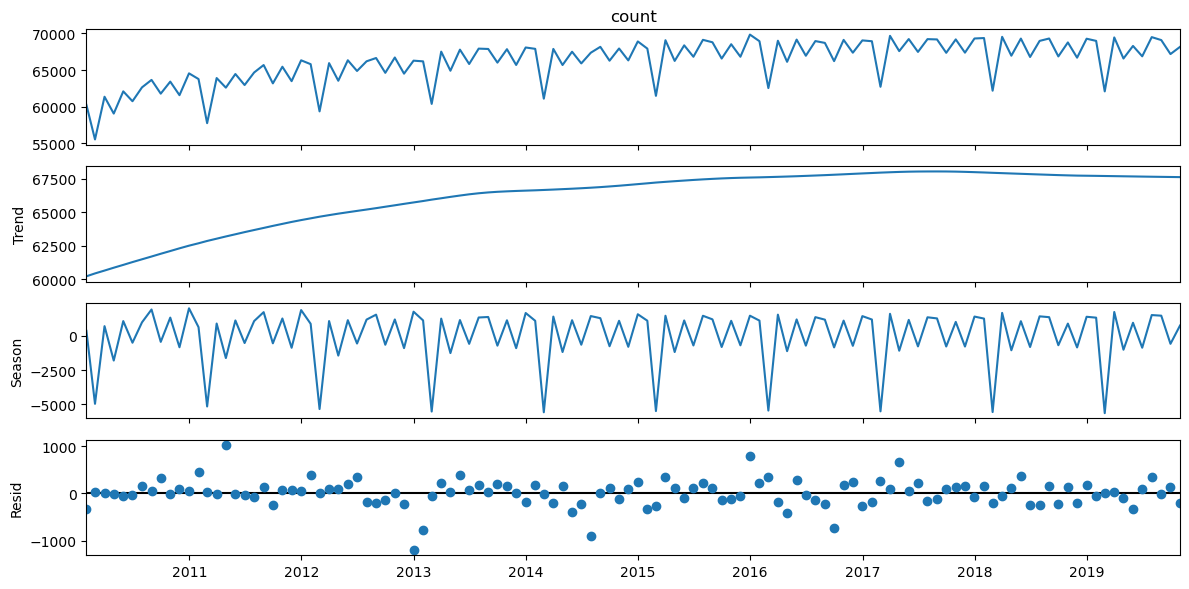

In [7]:
df = df[df["date"].notna()].copy()
y = (df.groupby(pd.Grouper(key="date", freq="M"))["id"].size().rename("count").asfreq("M").fillna(0)) 

stl = STL(y, period=12, robust=True).fit()
fig = stl.plot()
fig.set_size_inches(12, 6)
plt.tight_layout(); plt.show() 

In [8]:
H = 12  # 홀드아웃 12개월
train, test = y.iloc[:-H], y.iloc[-H:]

yhat_sn = y.shift(12).iloc[-H:]
def smape(a, f):
    a, f = np.array(a, float), np.array(f, float)
    den = (np.abs(a) + np.abs(f))
    return np.mean(np.where(den==0, 0.0, 2*np.abs(f-a)/den)) * 100

baseline_rmse = np.sqrt(np.mean((test - yhat_sn)**2))
baseline_smape = smape(test, yhat_sn)
print(f"[Seasonal Naive] RMSE={baseline_rmse:,.0f}  sMAPE={baseline_smape:.2f}%")

[Seasonal Naive] RMSE=464  sMAPE=0.54%


In [9]:
# SARIMAX 소그리드 탐색 (AIC 최소)
orders = [(1,1,1), (2,1,1), (1,1,2)]
seasonals = [(1,1,1,12), (0,1,1,12), (1,1,0,12)]
best = {"aic": np.inf}

for o, so in product(orders, seasonals):
    try:
        mod = sm.tsa.statespace.SARIMAX(train, order=o, seasonal_order=so,
                                        enforce_stationarity=False, enforce_invertibility=False)
        res = mod.fit(disp=False)
        if res.aic < best["aic"]:
            best = {"aic": res.aic, "order": o, "seasonal": so, "res": res}
    except Exception as e:
        continue

print(f"[Best SARIMAX] order={best['order']} seasonal={best['seasonal']}  AIC={best['aic']:.1f}")

[Best SARIMAX] order=(1, 1, 2) seasonal=(1, 1, 1, 12)  AIC=1183.6


In [10]:
# 홀드아웃 예측 성능
pred = best["res"].get_forecast(steps=H)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

rmse = np.sqrt(np.mean((test - pred_mean)**2))
smape_val = smape(test, pred_mean)
print(f"[SARIMAX Holdout] RMSE={rmse:,.0f}  sMAPE={smape_val:.2f}%  (vs SeasonalNaive RMSE={baseline_rmse:,.0f})")

[SARIMAX Holdout] RMSE=517  sMAPE=0.60%  (vs SeasonalNaive RMSE=464)


c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


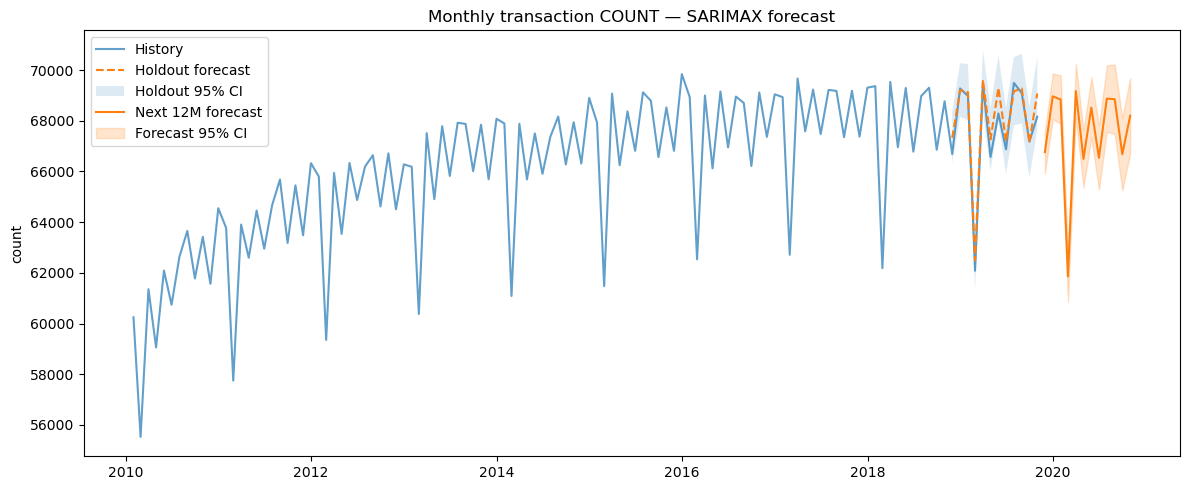

In [11]:
# 전체 데이터로 재학습 후 12개월 전망
final = sm.tsa.statespace.SARIMAX(y, order=best["order"], seasonal_order=best["seasonal"],
                                  enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
steps = 12
fc = final.get_forecast(steps=steps)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

plt.figure(figsize=(12,5))
plt.plot(y.index, y, label="History", alpha=0.7)
plt.plot(test.index, pred_mean, label="Holdout forecast", linestyle="--")
plt.fill_between(test.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], alpha=0.15, label="Holdout 95% CI")
plt.plot(fc_mean.index, fc_mean, label="Next 12M forecast", color="tab:orange")
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2, color="tab:orange", label="Forecast 95% CI")
plt.title("Monthly transaction COUNT — SARIMAX forecast")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

Top cities: ['Houston', 'Las Vegas', 'Oakland']


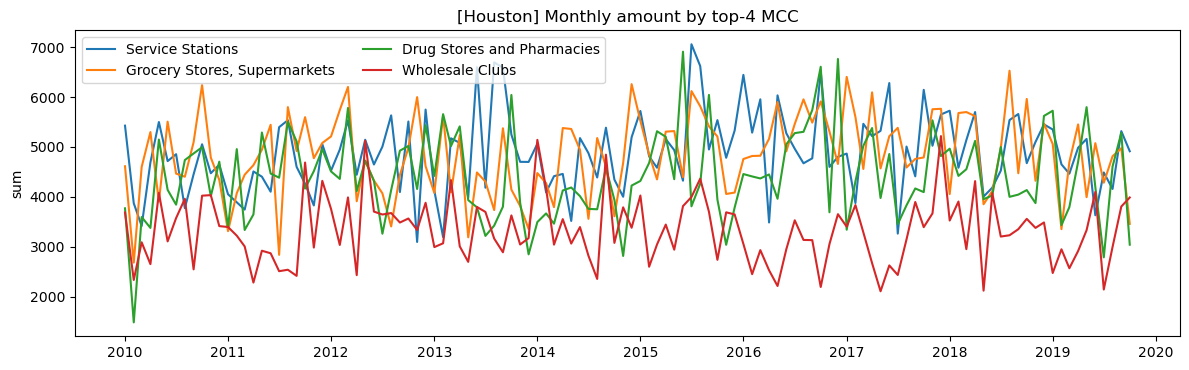

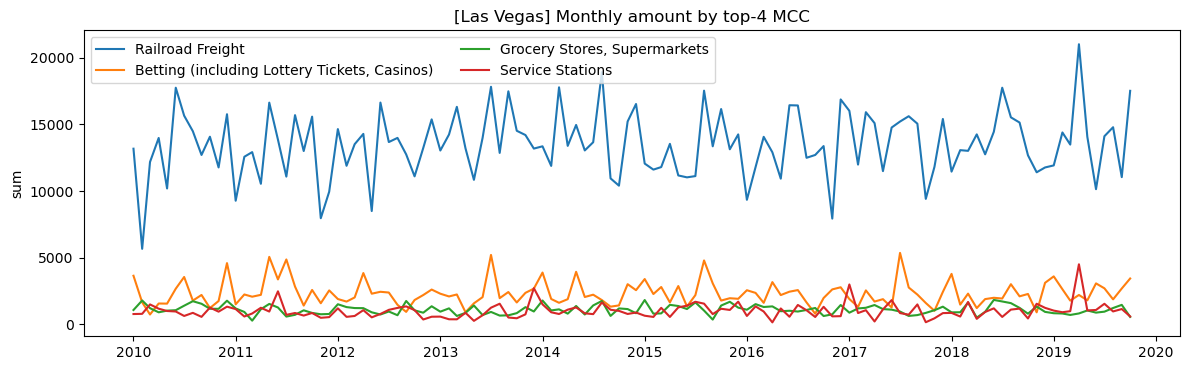

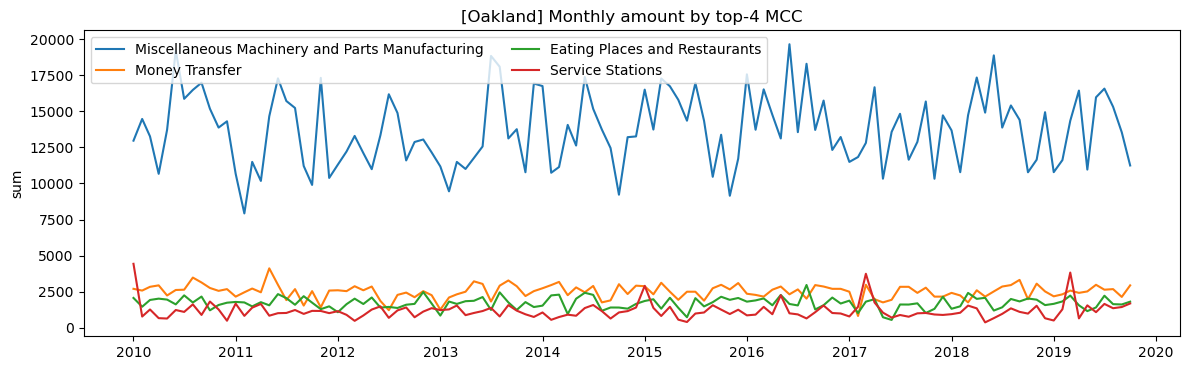

In [12]:
# 2. 거래도시별 업종 시계열 (City × Industry)

# 도시·업종별 월 금액
city_mcc_month = (df.groupby(["merchant_city","mcc_desc","month"])["amount_pos"].sum().reset_index())
city_mcc_month["month_ts"] = city_mcc_month["month"].dt.to_timestamp()

# 상위 도시 선정 (총 금액 기준)
top_cities = (df.groupby("merchant_city")["amount_pos"].sum()
                .sort_values(ascending=False).head(TOP_CITIES).index.tolist())
print("Top cities:", top_cities)

for city in top_cities:
    sub = city_mcc_month[city_mcc_month["merchant_city"]==city].copy()
    # 해당 도시 상위 업종 선정
    top_mcc = (sub.groupby("mcc_desc")["amount_pos"].sum()
                 .sort_values(ascending=False).head(TOP_MCC_PER_CITY).index.tolist())
    sub = sub[sub["mcc_desc"].isin(top_mcc)]

    fig, ax = plt.subplots(figsize=(12,3.8))
    for cat in top_mcc:
        s = sub[sub["mcc_desc"]==cat].set_index("month_ts")["amount_pos"].sort_index()
        ax.plot(s.index, s.values, label=str(cat))
    ax.set_title(f"[{city}] Monthly amount by top-{len(top_mcc)} MCC")
    ax.set_ylabel("sum")
    ax.legend(loc="upper left", ncol=2)
    plt.tight_layout()
    plt.show()

- [ONLINE]
  - 상위 MCC가 Tolls/Utilities/Telecom/Cable 같은 주기적 고정 청구(정기결제) 성격
  - 장기 우상향 + 변동성 낮음 → 사용자가 늘거나 온라인 청구로 전환이 지속된 신호
  - 월 단위 미세한 톱니 패턴(청구 주기)만 있고 급격한 시즌 피크는 약함
    - 금액이 안정적이라 비정상 패턴 탐지(평소 대비 갑작스런 증가/감소) 용이
    - 고객/가맹점 단위로 월주기 규칙성(autopay cadence) 피처를 만들면 이상 탐지 성능↑
- [Houston]
  - Service Stations / Grocery / Drugstores / Wholesale Clubs 등 생활 필수 업종이 상위권
  - 월별 진폭이 크고 규칙적으로 톱니 → 월/주간 시즌성이 분명
  - 유가·주행량 변화가 Service Stations 곡선의 레벨 이동을 만드는 것으로 보임
  - 전반적으로 장기 추세는 완만한 증가(중간중간의 급락은 시스템/집계 이슈 여부 점검 필요)
    - 주간/월간 시즌성(주말/월말 효과)가 강함
    - Service Stations는 유가·이동량과 동행 가능 → 외부 변수(평균 유가) 결합 시 설명력↑
- [Las Vegas]
  - Railroad Freight가 월등히 큼 → B2B 성격의 결제 비중이 크다는 시사
  - Betting(7995)가 뚜렷하게 존재하고, 후반부로 갈수록 완만한 증가 + 간헐적 스파이크
  - Grocery / Service Stations는 소규모이지만 규칙적 톱니 → 생활소비 패턴
    - Railroad Freight는 거래 규모가 커서 소수 이상치가 전체를 왜곡할 수 있음 → 로그/윈저라이즈 필요
    - Betting(7995)은 높은 위험군으로 알려져 있어 금액 상승·스파이크 구간은 우선 모니터링 대상

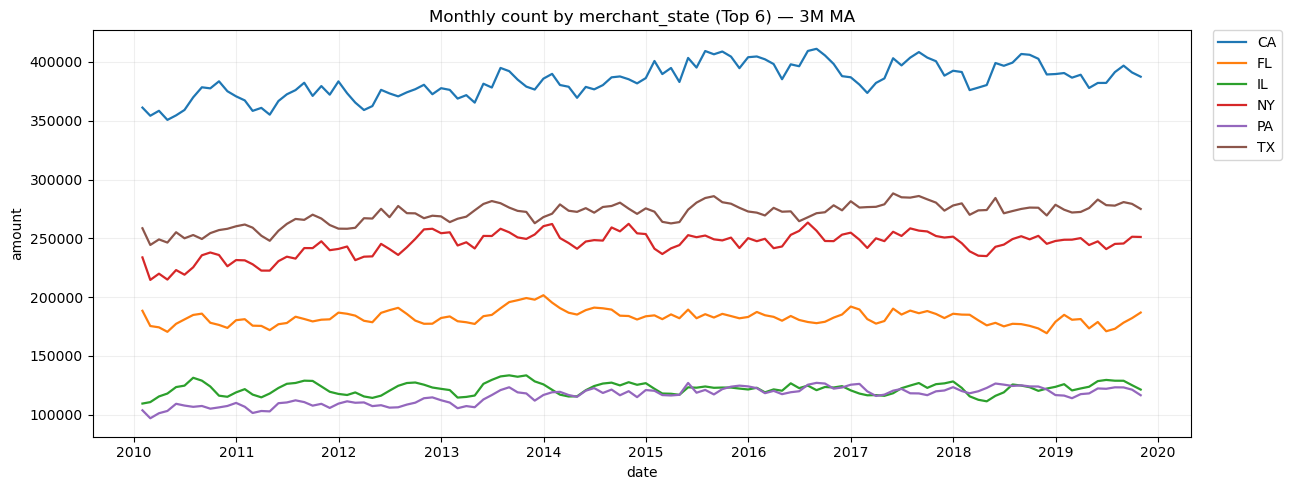

In [13]:
FREQ = "M"          
METRIC = "count"    
TOP_STATES = 6
SMOOTH = 3 if FREQ == "M" else 4 

df["_val"] = df["amount_pos"].astype(float) 
ylab = "amount"
g = (df.groupby(["merchant_state", pd.Grouper(key="date", freq=FREQ)])["_val"].sum().rename("value").reset_index())

top_states = (g.groupby("merchant_state")["value"].sum()
                .sort_values(ascending=False).head(TOP_STATES).index.tolist())

gp = g[g["merchant_state"].isin(top_states)]
pivot = (gp.pivot(index="date", columns="merchant_state", values="value").sort_index().asfreq(FREQ).fillna(0))
ma = pivot.rolling(SMOOTH, min_periods=1).mean()

plt.figure(figsize=(13,5))
for col in ma.columns:
    plt.plot(ma.index, ma[col], lw=1.6, label=col)
plt.title(f"{'Monthly' if FREQ=='M' else 'Weekly'} {METRIC} by merchant_state (Top {TOP_STATES}) — {SMOOTH}{'M' if FREQ=='M' else 'W'} MA")
plt.ylabel(ylab); plt.xlabel("date")
plt.grid(alpha=0.2)
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0, ncol=1)
plt.tight_layout()
plt.show()

State | SN sMAPE | SARIMAX sMAPE | Best(order)(seasonal)


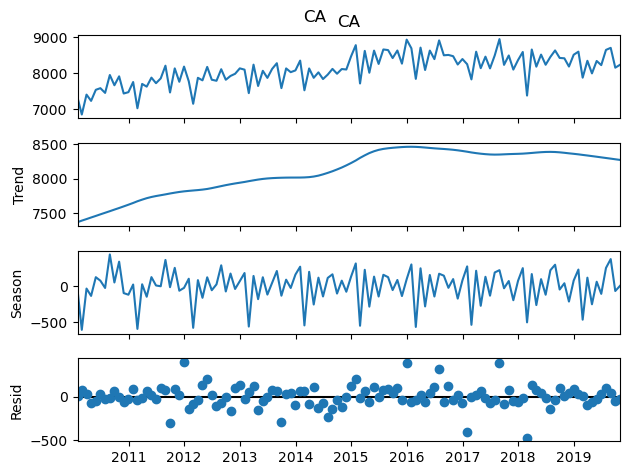

CA   |   2.18% |        1.84% | (1, 1, 2)(1, 1, 1, 12)


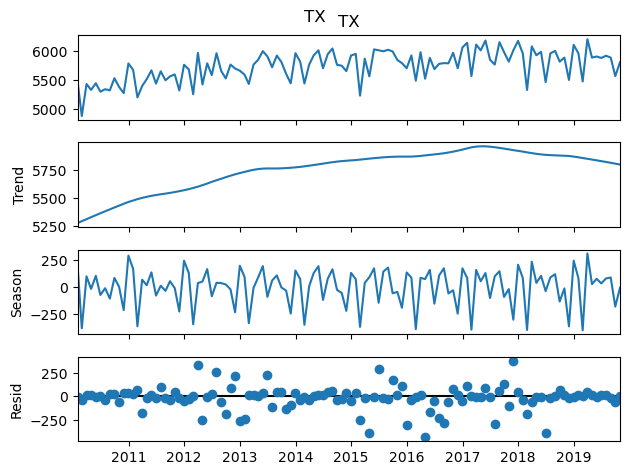

TX   |   2.72% |        2.45% | (1, 1, 2)(1, 1, 1, 12)


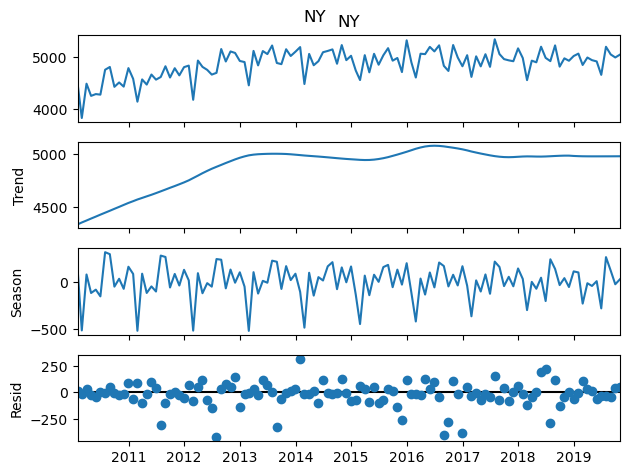

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NY   |   3.31% |        1.98% | (1, 1, 2)(1, 1, 1, 12)


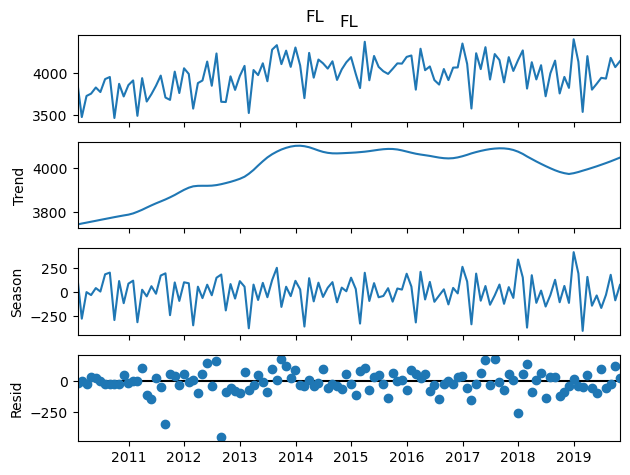

FL   |   4.46% |        3.58% | (1, 1, 2)(0, 1, 1, 12)


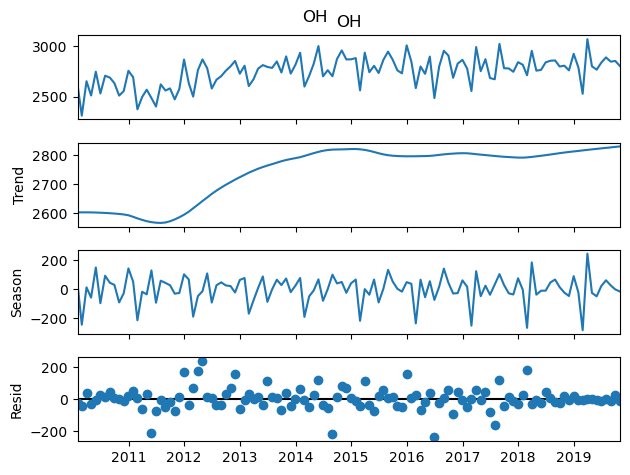

c:\Users\Administrator\anaconda3\envs\ds_study\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


OH   |   1.71% |        2.62% | (1, 1, 2)(0, 1, 1, 12)


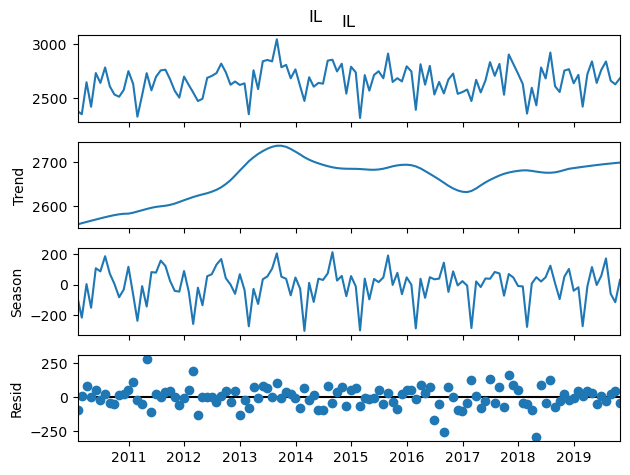

IL   |   4.15% |        3.20% | (1, 1, 2)(0, 1, 1, 12)


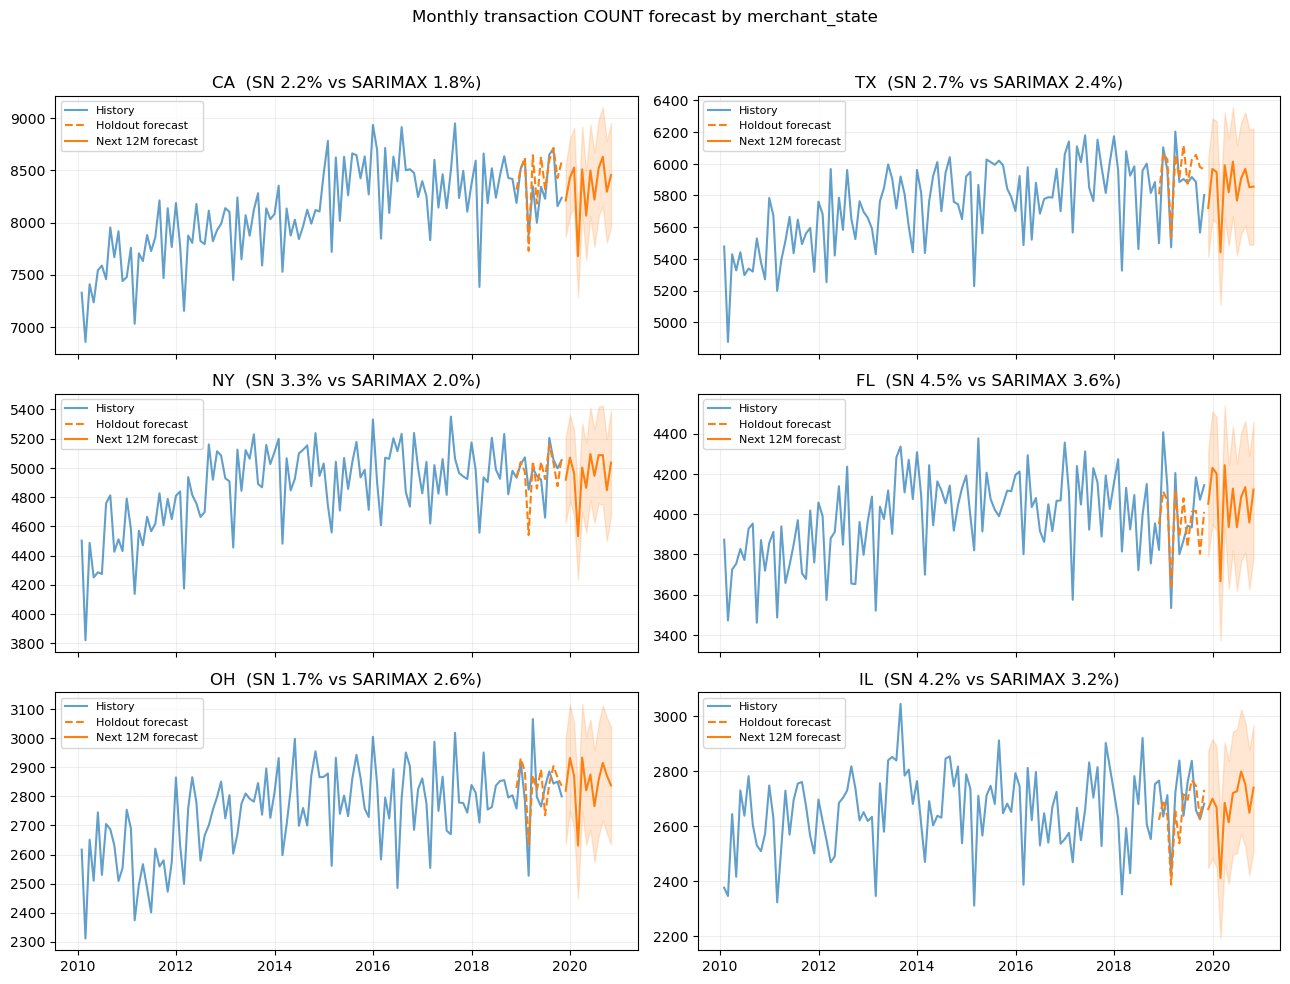

In [14]:
monthly_state = (df.groupby(["merchant_state", pd.Grouper(key="date", freq="M")])["id"].size().rename("count").reset_index())
top_states = (monthly_state.groupby("merchant_state")["count"].sum()
                .sort_values(ascending=False).head(TOP_STATES).index.tolist())

# 시계열 피벗 
Y = (monthly_state[monthly_state["merchant_state"].isin(top_states)]
       .pivot(index="date", columns="merchant_state", values="count")
       .asfreq("M").fillna(0).sort_index())

#  1) 유틸 
def smape(a, f):
    a, f = np.asarray(a, float), np.asarray(f, float)
    den = np.abs(a) + np.abs(f)
    return np.mean(np.where(den==0, 0, 2*np.abs(f-a)/den)) * 100

def fit_best_sarimax(y_train):
    """작은 그리드로 AIC 최소 모델 선택"""
    orders = [(1,1,1), (2,1,1), (1,1,2)]
    seasonals = [(1,1,1,12), (0,1,1,12), (1,1,0,12)]
    best = {"aic": np.inf, "res": None, "order": None, "seasonal": None}
    for o, so in product(orders, seasonals):
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train, order=o, seasonal_order=so,
                                            enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            if res.aic < best["aic"]:
                best = {"aic": res.aic, "res": res, "order": o, "seasonal": so}
        except Exception:
            pass
    return best

#  2) 각 주 평가(홀드아웃 12개월) & 예측 12개월 
H, STEPS = 12, 12
results = {}
print("State | SN sMAPE | SARIMAX sMAPE | Best(order)(seasonal)")
for st in top_states:
    y = Y[st]
    STL(y, period=12, robust=True).fit().plot(); plt.suptitle(st); plt.show()
    train, test = y.iloc[:-H], y.iloc[-H:]

    # Seasonal naive
    yhat_sn = y.shift(12).iloc[-H:]
    base_smape = smape(test, yhat_sn)

    # SARIMAX
    best = fit_best_sarimax(train)
    pred = best["res"].get_forecast(steps=H).predicted_mean
    model_smape = smape(test, pred)

    # 전체 재학습 후 12개월 예측
    final = sm.tsa.statespace.SARIMAX(y, order=best["order"], seasonal_order=best["seasonal"],
                                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    fc = final.get_forecast(steps=STEPS)
    results[st] = {"hist": y, "holdout_pred": pred, "holdout_true": test,
                   "fc_mean": fc.predicted_mean, "fc_ci": fc.conf_int(),
                   "order": best["order"], "seasonal": best["seasonal"],
                   "smape_sn": base_smape, "smape_sarimax": model_smape}
    print(f"{st:>2}   | {base_smape:6.2f}% | {model_smape:11.2f}% | {best['order']}{best['seasonal']}")

#  3) 플롯: 상위 주 여러 개 
n = len(top_states)
ncols, nrows = 2, int(np.ceil(n/2))
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 3.2*nrows), sharex=True)
axes = axes.ravel()

for i, st in enumerate(top_states):
    ax = axes[i]
    r = results[st]
    ax.plot(r["hist"].index, r["hist"].values, label="History", alpha=0.7)
    ax.plot(r["holdout_true"].index, r["holdout_pred"].values, ls="--", label="Holdout forecast")
    ax.plot(r["fc_mean"].index, r["fc_mean"].values, color="tab:orange", label="Next 12M forecast")
    ci = r["fc_ci"]
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="tab:orange", alpha=0.18)
    ax.set_title(f"{st}  (SN {r['smape_sn']:.1f}% vs SARIMAX {r['smape_sarimax']:.1f}%)")
    ax.grid(alpha=0.2); ax.legend(fontsize=8, loc="upper left")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Monthly transaction COUNT forecast by merchant_state", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

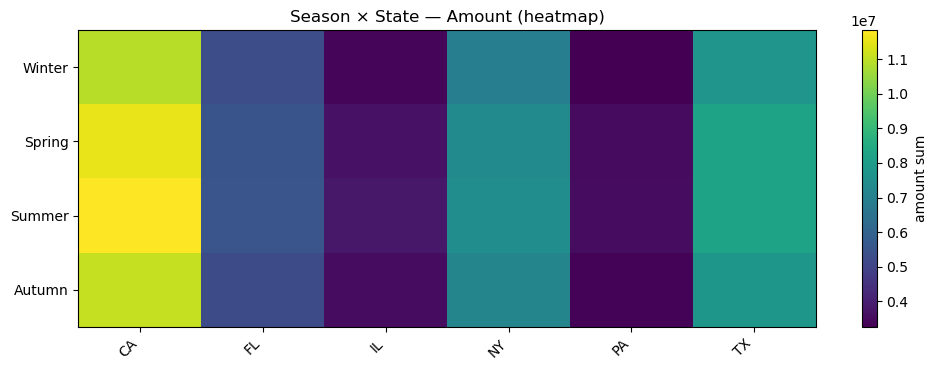

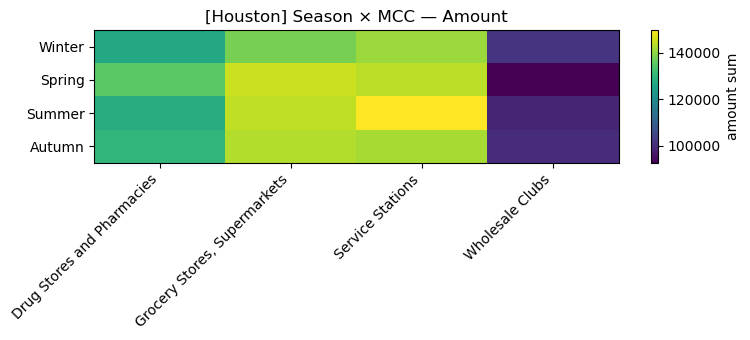

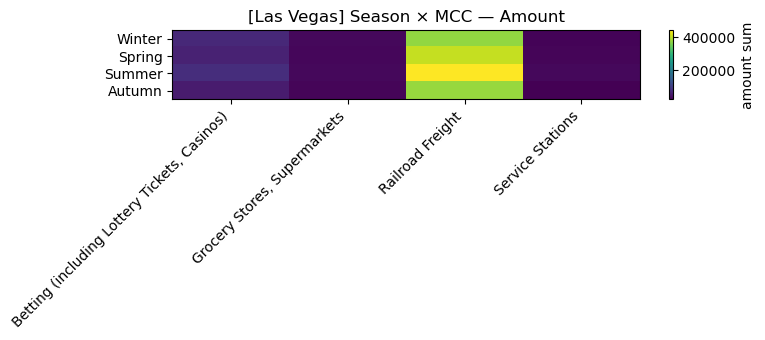

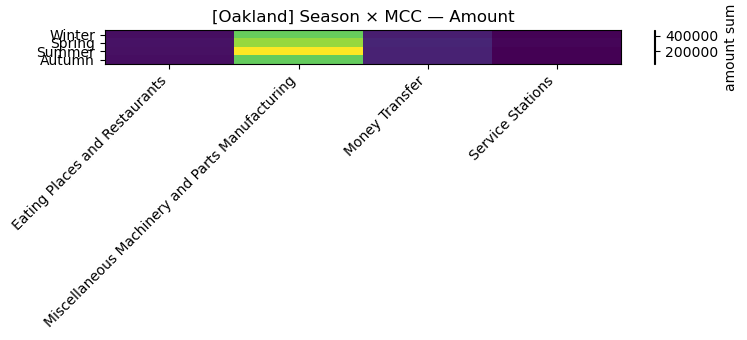

In [15]:
# 3. (1)+(2)의 주제에서 '계절(Season)·지역' 도식화
#    - Season 정의: Winter(12,1,2) / Spring(3-5) / Summer(6-8) / Autumn(9-11)
#    - 지역: 주(merchant_state) 기준

season_map = {12:"Winter",1:"Winter",2:"Winter",3:"Spring",4:"Spring",5:"Spring",
              6:"Summer",7:"Summer",8:"Summer",9:"Autumn",10:"Autumn",11:"Autumn"}
df["season"] = df["date"].dt.month.map(season_map)

# (A) 금액: season × state heatmap (상위 주만)
state_total = df.groupby("merchant_state")["amount_pos"].sum().sort_values(ascending=False)
keep_states = state_total.head(TOP_STATES).index.tolist()
pivot_amt = (df[df["merchant_state"].isin(keep_states)]
             .pivot_table(index="season", columns="merchant_state", values="amount_pos", aggfunc="sum").fillna(0))
# season 순서 고정
pivot_amt = pivot_amt.reindex(["Winter","Spring","Summer","Autumn"])

plt.figure(figsize=(1.2*len(keep_states)+3, 3.8))
plt.imshow(pivot_amt.values, aspect="auto")
plt.yticks(range(len(pivot_amt.index)), pivot_amt.index)
plt.xticks(range(len(pivot_amt.columns)), pivot_amt.columns, rotation=45, ha="right")
plt.colorbar(label="amount sum")
plt.title("Season × State — Amount (heatmap)")
plt.tight_layout(); plt.show()

# (B) 도시×업종: season 레벨 요약 (Top cities 기준)
city_mcc_season = (df[df["merchant_city"].isin(top_cities)]
   .groupby(["merchant_city","mcc_desc","season"])["amount_pos"].sum().reset_index())

for city in top_cities:
    sub = city_mcc_season[city_mcc_season["merchant_city"]==city].copy()
    # 해당 도시 상위 업종 고정 (앞에서와 동일 기준)
    top_mcc = (sub.groupby("mcc_desc")["amount_pos"].sum()
                 .sort_values(ascending=False).head(TOP_MCC_PER_CITY).index.tolist())
    sub = sub[sub["mcc_desc"].isin(top_mcc)]
    pivot_city = (sub.pivot_table(index="season", columns="mcc_desc", values="amount_pos", aggfunc="sum")
                     .reindex(["Winter","Spring","Summer","Autumn"]).fillna(0))

    plt.figure(figsize=(1.2*len(pivot_city.columns)+3, 3.5))
    plt.imshow(pivot_city.values, aspect="auto")
    plt.yticks(range(4), ["Winter","Spring","Summer","Autumn"])
    plt.xticks(range(len(pivot_city.columns)), pivot_city.columns, rotation=45, ha="right")
    plt.colorbar(label="amount sum")
    plt.title(f"[{city}] Season × MCC — Amount")
    plt.tight_layout(); plt.show()

- 지역 
  - 매출(금액) 측면에서 CA·TX가 리스크·기회 모두의 중심
  -  봄·여름에 운영/모니터링 리소스 집중이 합리적
- ONLINE
  - 시즌성 약 → 기저선(평균) 대비 편차가 더 중요한 신호
- Houston—연료 주도형 시즌성
  - 여름 유류비/이동량↑이 주유소 금액을 밀어 올림
  - 유가/휴가철 외생 변수 결합 시 설명력↑
- Las Vegas—특수 업종 주도
  - Freight가 전체를 좌우 → 모델링 시 로그/윈저라이즈로 이상치 영향 완화
  - Betting(7995)은 일반적으로 상대 고위험 MCC 
  - 봄·여름의 완만한 증가 구간을 우선 모니터링 후보로

In [16]:
df0 = df.copy(deep=True)
df0 = df0[df0["date"].notna()].copy()
df0["month"] = df0["date"].dt.to_period("M")

TOP_CITIES = 3
TOP_MCC_PER_CITY = 4

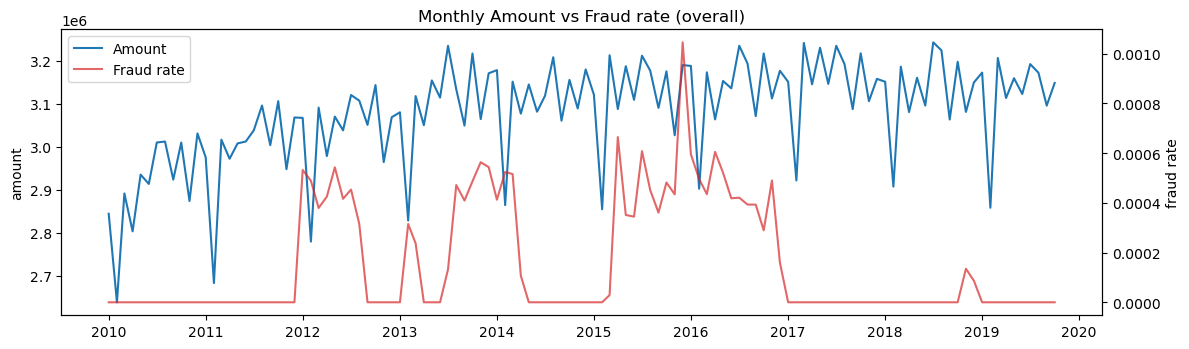

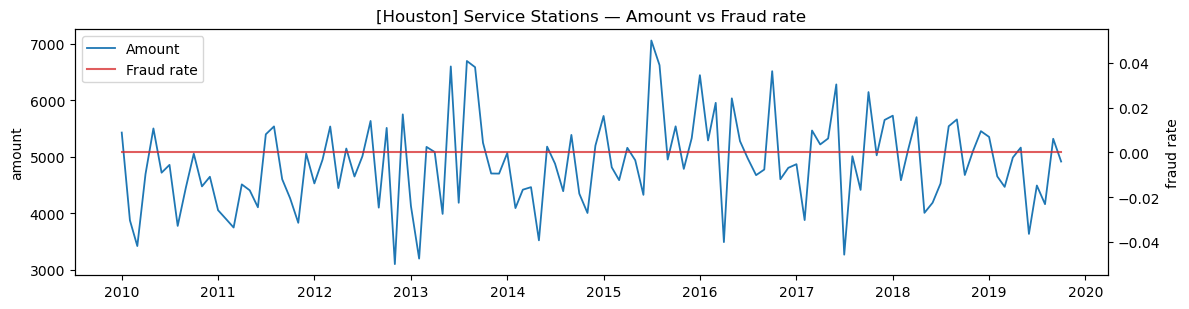

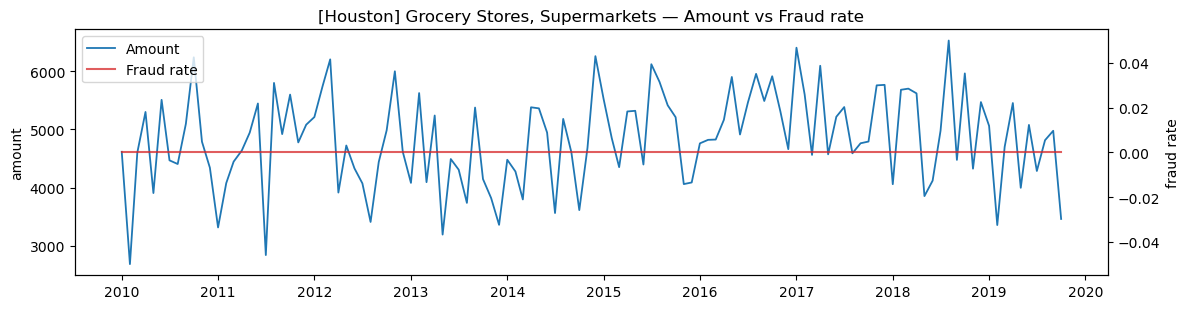

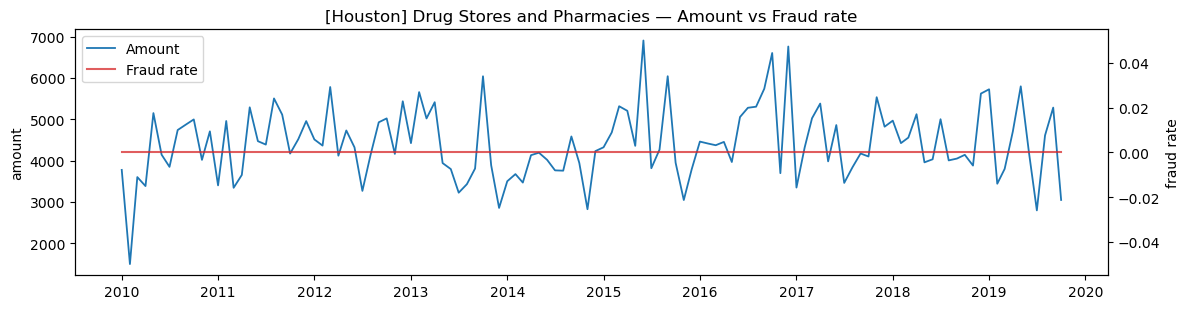

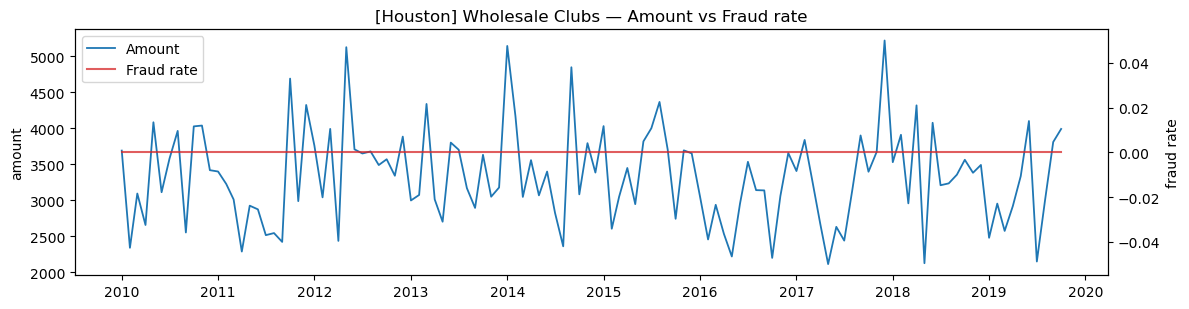

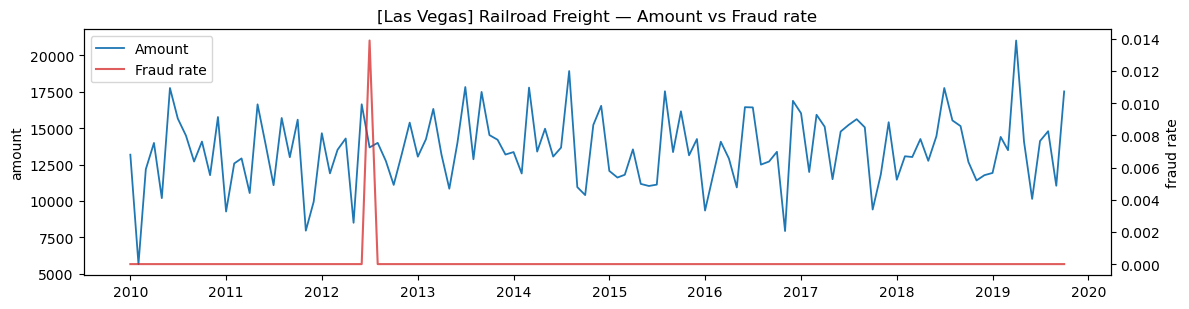

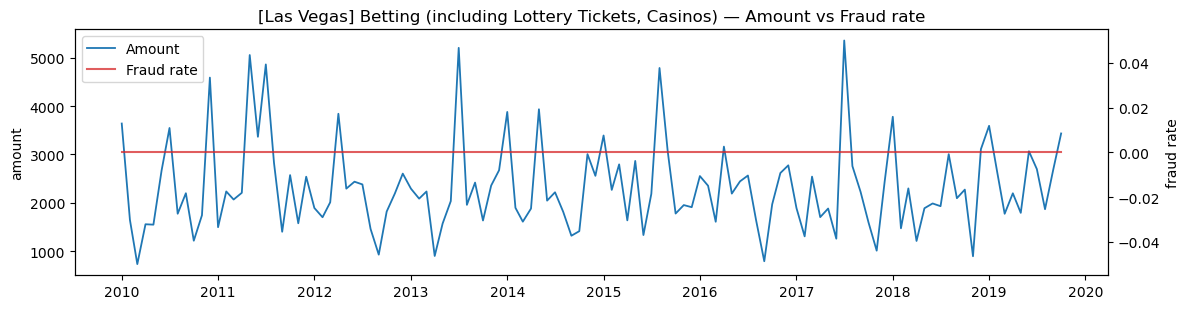

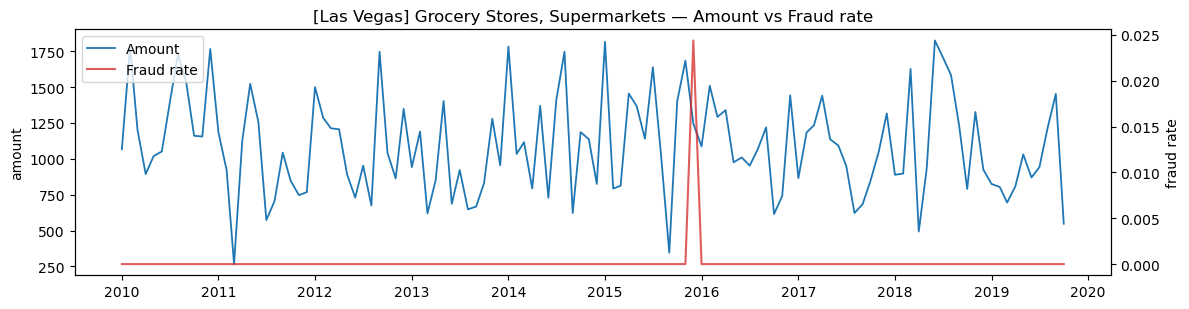

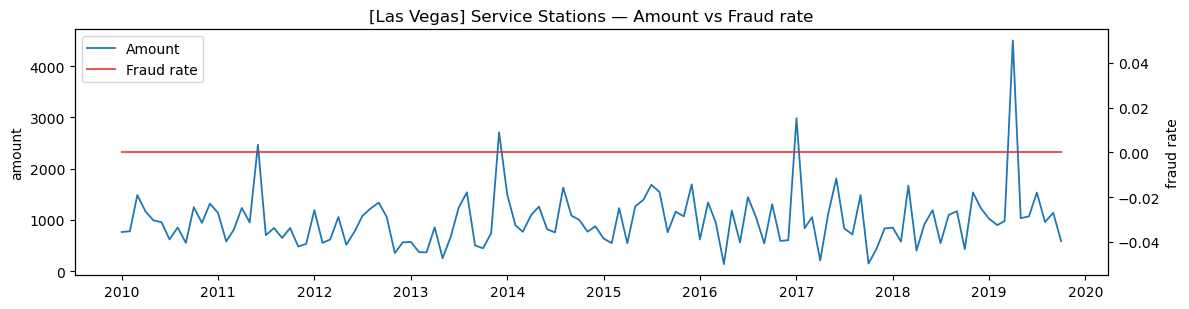

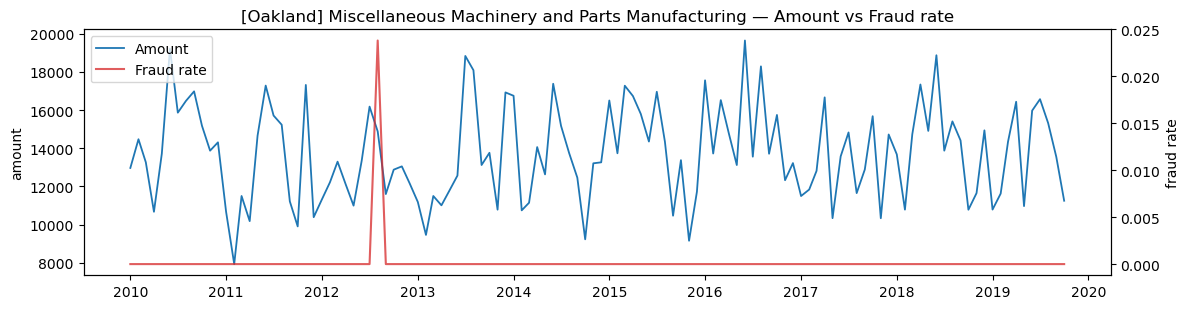

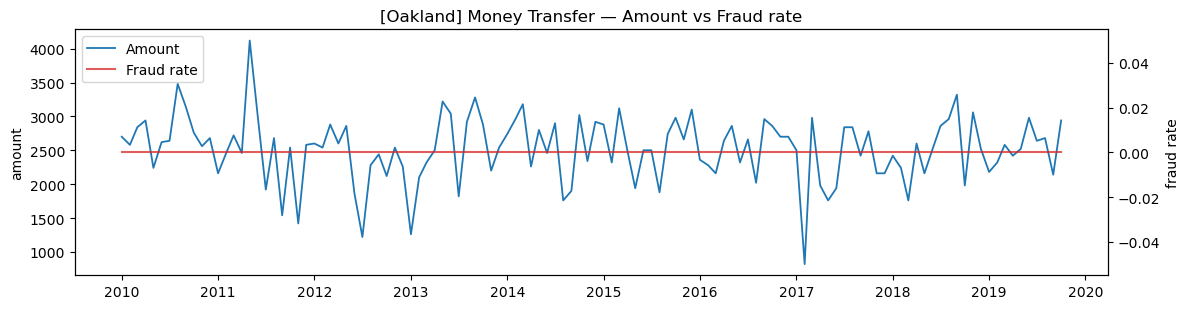

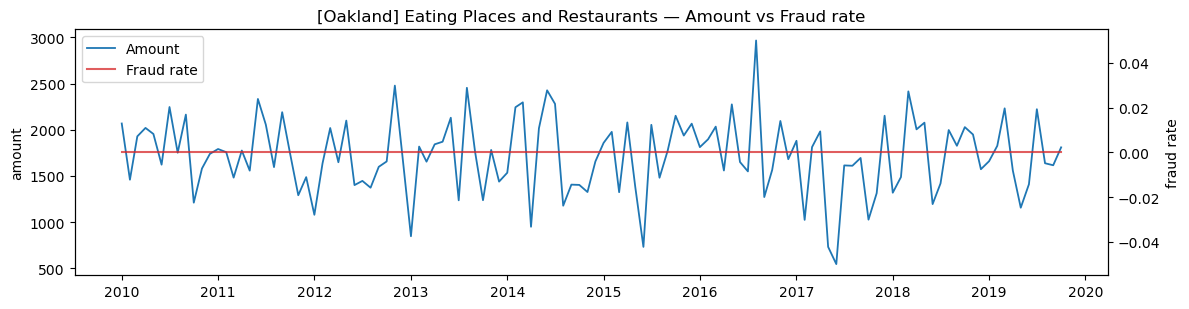

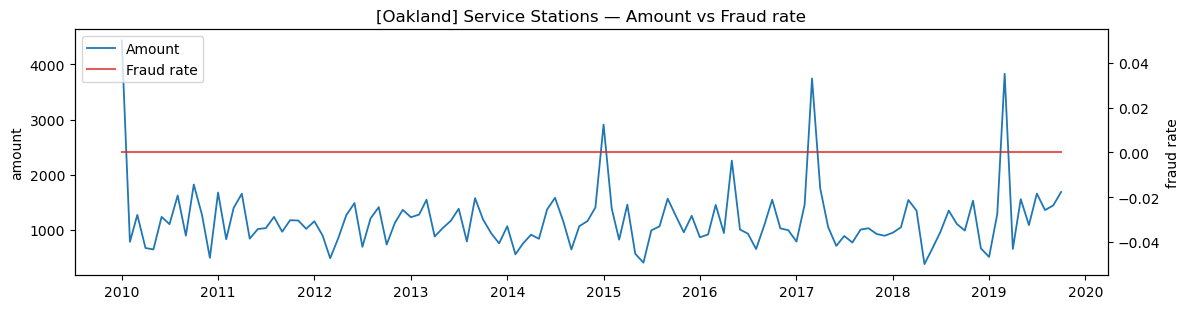

In [17]:
# 4) 사기 데이터 엮기 (fraud coupling)
#    - 월별 금액/거래/사기율
#    - 도시×업종 월별 금액 vs 사기율(좌/우축)

# 전체 월별
monthly_agg = (df0.groupby("month").agg(n=("id","size"),amount=("amount_pos","sum"),
                                     frauds=("is_fraud","sum")).sort_index().reset_index())
monthly_agg["ts"]   = monthly_agg["month"].dt.to_timestamp()
monthly_agg["rate"] = monthly_agg["frauds"] / monthly_agg["n"].replace(0, np.nan)

fig, ax1 = plt.subplots(figsize=(12,3.6))
ax1.plot(monthly_agg["ts"], monthly_agg["amount"], label="Amount", lw=1.5)
ax1.set_ylabel("amount")
ax2 = ax1.twinx()
ax2.plot(monthly_agg["ts"], monthly_agg["rate"], label="Fraud rate", color="tab:red", alpha=0.7)
ax2.set_ylabel("fraud rate")
ax1.set_title("Monthly Amount vs Fraud rate (overall)")
l1,lbl1 = ax1.get_legend_handles_labels(); l2,lbl2 = ax2.get_legend_handles_labels()
ax1.legend(l1+l2, lbl1+lbl2, loc="upper left")
plt.tight_layout(); plt.show()

# ========== 도시×업종 월별: Amount vs Fraud rate ==========
# (A) 상위 도시 선정(항상 같은 규칙)
top_cities = (df0.groupby("merchant_city")["amount_pos"].sum()
                .sort_values(ascending=False).head(TOP_CITIES).index.tolist())

# (B) 월별 집계 (연-월 기준)
city_mcc_month_full = (df0.groupby(["merchant_city","mcc_desc","month"])
                       .agg(n=("id","size"), amount=("amount_pos","sum"),
                            frauds=("is_fraud","sum")).reset_index())
city_mcc_month_full["ts"]   = city_mcc_month_full["month"].dt.to_timestamp()
city_mcc_month_full["rate"] = city_mcc_month_full["frauds"] / city_mcc_month_full["n"].replace(0,np.nan)

# (C) 도시별 상위 업종 고정 + 플롯
for city in top_cities:
    sub_city = city_mcc_month_full[city_mcc_month_full["merchant_city"]==city].copy()
    top_mcc = (sub_city.groupby("mcc_desc")["amount"]
                 .sum().sort_values(ascending=False).head(TOP_MCC_PER_CITY).index.tolist())
    for mcc_name in top_mcc:
        s = sub_city[sub_city["mcc_desc"]==mcc_name].sort_values("ts")
        fig, ax1 = plt.subplots(figsize=(12,3.2))
        ax1.plot(s["ts"], s["amount"], label="Amount", lw=1.3)
        ax1.set_ylabel("amount")
        ax2 = ax1.twinx()
        ax2.plot(s["ts"], s["rate"], label="Fraud rate", color="tab:red", alpha=0.75)
        ax2.set_ylabel("fraud rate")
        ax1.set_title(f"[{city}] {mcc_name} — Amount vs Fraud rate")
        l1,lbl1 = ax1.get_legend_handles_labels(); l2,lbl2 = ax2.get_legend_handles_labels()
        ax1.legend(l1+l2, lbl1+lbl2, loc="upper left")
        plt.tight_layout(); plt.show()

[INFO] Skipped MCCs due to no valid overlap: 35
[overall] Top similar MCC by |best_corr| (lag in [-6,6])
                                    mcc_desc  corr0  best_corr  best_lag  n_used
                       Digital Goods - Games  0.993      0.998         1      25
                             Wholesale Clubs  0.916      0.916         0     118
                Grocery Stores, Supermarkets  0.909      0.909         0     118
          Package Stores, Beer, Wine, Liquor  0.900      0.900         0     118
                  Drug Stores and Pharmacies  0.867      0.867         0     118
                      Family Clothing Stores  0.865      0.865         0     118
                             Discount Stores  0.863      0.863         0     118
       Drinking Places (Alcoholic Beverages)  0.812      0.812         0     118
               Eating Places and Restaurants  0.800      0.806         1     117
                  Precious Stones and Metals  0.785      0.791        -1     117
    

Text(0.5, 0.98, 'MCC with similar cycle to OVERALL fraud rate (3M MA)')

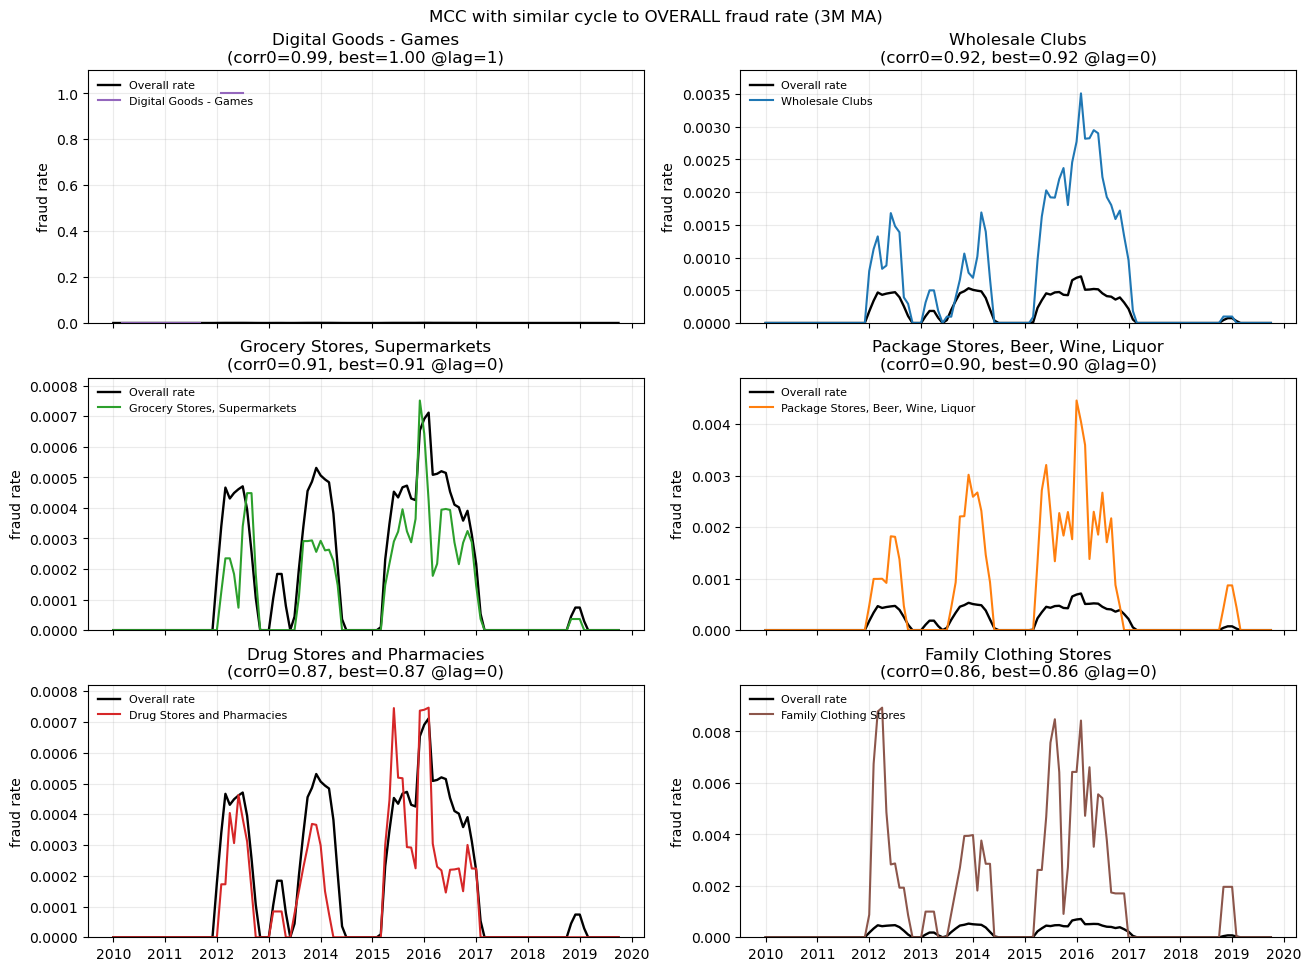

In [ ]:
# MCC 중에서 전체 사기율과 비슷한 사이클을 보이는 업종 찾기
#  - 월별 3개월 이동평균, z-score 불필요(상관으로 스케일 무관)
#  - lag=±6개월까지 교차상관 최대값으로 랭킹

# 전체 월별 사기율
mon_all = (df.groupby("month").agg(n=("id","size"), frauds=("is_fraud","sum")).sort_index())
rate_overall = (mon_all["frauds"] / mon_all["n"].replace(0, np.nan)).rolling(3, min_periods=1).mean()

# 통신 사기율도 
tel_mask = df["mcc_desc"].astype("string").str.contains("Telecommunication", case=False, na=False)
mon_tel = (df[tel_mask].groupby("month").agg(n=("id","size"), frauds=("is_fraud","sum")).sort_index())
rate_tel = (mon_tel["frauds"] / mon_tel["n"].replace(0, np.nan)).rolling(3, min_periods=1).mean()

# 타깃 시계열 지정: 'overall' 또는 'telecom' 중 택1
TARGET = "overall"        # <- "telecom"으로 바꾸면 통신과 유사한 MCC를 찾음
target_rate = rate_overall if TARGET=="overall" else rate_tel

#  1) MCC별 월 사기율 피벗 
mcc_mon = (df.groupby(["mcc_desc","month"]).agg(n=("id","size"), 
                                                 frauds=("is_fraud","sum")).reset_index())
mcc_mon["rate"] = mcc_mon["frauds"] / mcc_mon["n"].replace(0, np.nan)

pivot_rate = (mcc_mon.pivot(index="month", columns="mcc_desc", values="rate")
              .sort_index().rolling(3, min_periods=1).mean())  

# 충분한 기간이 있는 MCC만 남기기
MIN_MONTHS = 24
valid_cols = pivot_rate.columns[pivot_rate.notna().sum() >= MIN_MONTHS]
pivot_rate = pivot_rate[valid_cols]

#  2) 안전한 교차상관 함수 
def xcorr(x: pd.Series, y: pd.Series, max_lag=6, min_samples=6):
    x = x.astype(float).sort_index()
    y = y.astype(float).sort_index()
    idx = x.index.intersection(y.index)
    x, y = x.loc[idx], y.loc[idx]
    rows = []
    for L in range(-max_lag, max_lag+1):
        yy = y.shift(-L)
        pair = pd.concat([x, yy], axis=1).dropna()
        corr = pair.iloc[:,0].corr(pair.iloc[:,1]) if len(pair) >= min_samples else np.nan
        rows.append((L, corr, len(pair)))
    out = pd.DataFrame(rows, columns=["lag","corr","n_used"]).set_index("lag")
    return out

#  3) MCC별 유사도 산출 (robust) 
MAX_LAG = 6
MIN_SAMPLES = 6   

rows, skipped = [], 0
for col, s in pivot_rate.items():
    # lag=0 상관
    joined0 = pd.concat([s, target_rate], axis=1).dropna()
    corr0 = joined0.iloc[:, 0].corr(joined0.iloc[:, 1]) if len(joined0) >= MIN_SAMPLES else np.nan
    # 교차상관
    ccf = xcorr(s, target_rate, max_lag=MAX_LAG, min_samples=MIN_SAMPLES)
    valid = ccf["corr"].notna()
    if not valid.any():    
        skipped += 1
        continue
    best_lag  = int(ccf.loc[valid, "corr"].abs().idxmax())
    best_corr = float(ccf.loc[best_lag, "corr"])
    n_used    = int(ccf.loc[best_lag, "n_used"])
    rows.append((col, corr0, best_corr, best_lag, n_used))

rank = (pd.DataFrame(rows, columns=["mcc_desc","corr0","best_corr","best_lag","n_used"])
          .sort_values("best_corr", ascending=False)
          .reset_index(drop=True))

print(f"[INFO] Skipped MCCs due to no valid overlap: {skipped}")
print(f"[{TARGET}] Top similar MCC by |best_corr| (lag in [-{MAX_LAG},{MAX_LAG}])")
print(rank.head(15).round(3).to_string(index=False))

#  4) 상위 K개 시각화 
TOP_K = 6
colors = ["#9467bd","#1f77b4","#2ca02c","#ff7f0e","#d62728","#8c564b"]
target_color = "black"

metrics = rank.set_index("mcc_desc")
top_mccs = metrics.head(TOP_K).index.tolist()
plt.close('all')

# 여백/제목 충돌을 자동으로 조정
ncols = 2
nrows = int(np.ceil(max(1, len(top_mccs)) / ncols))
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(13, 3.2*nrows),
                         sharex=True,constrained_layout=True,  )

if isinstance(axes, np.ndarray):
    axes = axes.ravel()
else:
    axes = np.array([axes])

ts = target_rate.index.to_timestamp()
for i, mcc in enumerate(top_mccs):
    ax = axes[i]
    s = pivot_rate[mcc].reindex(target_rate.index)

    ax.plot(ts, target_rate.values, lw=1.7, color=target_color,
            label=("Overall rate" if TARGET=="overall" else "Telecom rate"))
    ax.plot(ts, s.values, lw=1.5, color=colors[i % len(colors)], label=mcc)

    m = np.nanmax([np.nanmax(target_rate.values), np.nanmax(s.values)])
    if np.isfinite(m) and m > 0:
        ax.set_ylim(0, m * 1.1)
    ax.set_ylabel("fraud rate")
    info = metrics.loc[mcc]
    ax.set_title(f"{mcc}\n(corr0={info['corr0']:.2f}, best={info['best_corr']:.2f} @lag={int(info['best_lag'])})")
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left", fontsize=8, frameon=False)

for j in range(len(top_mccs), len(axes)):
    axes[j].set_visible(False)
    axes[j].axis("off")

fig.suptitle(f"MCC with similar cycle to {TARGET.upper()} fraud rate (3M MA)", fontsize=12)